## モデルの学習 by Pytorch
GPUないときついかも  
モデルはテキトー

Epoch 1/20
Train Loss: 14.1168, Train Accuracy: 0.45
Test Loss: 9.5775, Test Accuracy: 0.53
Epoch 2/20
Train Loss: 4.8147, Train Accuracy: 0.67
Test Loss: 2.9772, Test Accuracy: 0.71
Epoch 3/20
Train Loss: 3.4829, Train Accuracy: 0.72
Test Loss: 2.4094, Test Accuracy: 0.77
Epoch 4/20
Train Loss: 2.7541, Train Accuracy: 0.78
Test Loss: 2.2362, Test Accuracy: 0.78
Epoch 5/20
Train Loss: 1.7555, Train Accuracy: 0.82
Test Loss: 1.6956, Test Accuracy: 0.83
Epoch 6/20
Train Loss: 2.6324, Train Accuracy: 0.79
Test Loss: 2.1908, Test Accuracy: 0.80
Epoch 7/20
Train Loss: 1.2833, Train Accuracy: 0.86
Test Loss: 1.1424, Test Accuracy: 0.86
Epoch 8/20
Train Loss: 1.2530, Train Accuracy: 0.86
Test Loss: 0.4660, Test Accuracy: 0.91
Epoch 9/20
Train Loss: 0.7652, Train Accuracy: 0.90
Test Loss: 0.5399, Test Accuracy: 0.92
Epoch 10/20
Train Loss: 0.5285, Train Accuracy: 0.91
Test Loss: 0.3693, Test Accuracy: 0.92
Epoch 11/20
Train Loss: 0.3653, Train Accuracy: 0.94
Test Loss: 0.4261, Test Accuracy: 0

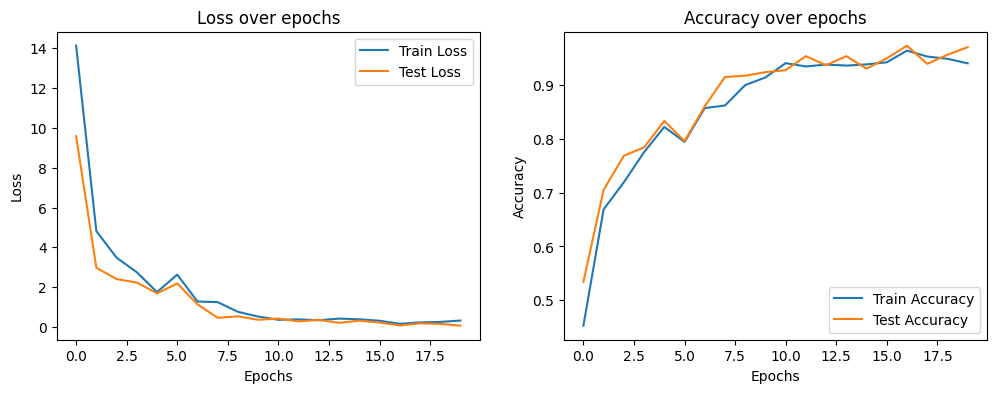

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
import PIL.Image as Image
import matplotlib.pyplot as plt

data_dir = '../generate/image/paste'

input_size = 32
batch_size = 32

# カスタムデータセットクラス
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.classes = ['left_near', 'left_just', 'left_far', 
                        'middle_near', 'middle_just', 'middle_far', 
                        'right_near', 'right_just', 'right_far']
        self.images = []
        self.labels = []

        for idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(self.data_dir, class_name)
            for img_name in os.listdir(class_dir):
                self.images.append(os.path.join(class_dir, img_name))
                self.labels.append(idx)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# データ変換ルールの定義
transform = transforms.Compose([
    transforms.Resize((input_size, input_size)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomVerticalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

# 全データセットのロード
full_dataset = CustomDataset(data_dir=data_dir, transform=transform)

# データセットの長さ
dataset_size = len(full_dataset)
train_size = int(dataset_size * 0.8)
test_size = dataset_size - train_size

# トレーニングセットとテストセットに分割
train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])

# データローダーの定義
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

畳み込みニューラルネットワークモデル
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(32 * 64 * 64, 9)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out


class AdvancedConvNet(nn.Module):
    def __init__(self):
        super(AdvancedConvNet, self).__init__()
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 32 * 32, 512) # Adjust the dimensions according to your input image size
        self.fc2 = nn.Linear(512, 9)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1) # Flatten the tensor
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x
    
class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=1000):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

def ResNet50():
    return ResNet(Bottleneck, [3, 4, 6, 3])


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != self.expansion * out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, self.expansion * out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * out_channels)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class TinyResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(TinyResNet, self).__init__()
        self.in_channels = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(64 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_channels, out_channels, stride))
            self.in_channels = out_channels * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avgpool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

def TinyResNet18():
    return TinyResNet(BasicBlock, [2, 2, 2, 2], num_classes=10)



# GPUの利用確認
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# モデルをデバイスに移動
model = ConvNet().to(device)

# 損失関数とオプティマイザの定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# トレーニングとテスト関数
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / len(train_loader), correct / total

def test(model, test_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / len(test_loader), correct / total

# トレーニングとテストの結果を記録
train_losses = []
train_accuracy = []
test_losses = []
test_accuracy = []




In [ ]:
# トレーニングループ
num_epochs = 20
for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    test_loss, test_acc = test(model, test_loader, criterion, device)

    train_losses.append(train_loss)
    train_accuracy.append(train_acc)
    test_losses.append(test_loss)
    test_accuracy.append(test_acc)

    print(f'Epoch {epoch + 1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}')
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}')

# 結果のグラフ表示
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(test_accuracy, label='Test Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 訓練したモデルを利用し、予測
新しい画像を用いて、出力を確認してみよう。

In [9]:
from PIL import Image
import torchvision.transforms as transforms

def predict(image_path):
# 新しい画像の読み込み
    image = Image.open(image_path).convert('RGB')

    # 画像の前処理
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
    image = transform(image)
    image = image.unsqueeze(0)  # バッチ次元の追加

    # デバイスの設定
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    image = image.to(device)

    # モデルの評価モード
    model.eval()

    # 予測
    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    # クラス名の取得
    classes = ['left_near', 'left_just', 'left_far', 
               'middle_near', 'middle_just', 'middle_far', 
               'right_near', 'right_just', 'right_far']
    predicted_class = classes[predicted.item()]

    print(f'Predicted Class: {predicted_class}')


## 画像のpathを取得

In [10]:
import glob

classes = ['left_near', 'left_just', 'left_far', 
               'middle_near', 'middle_just', 'middle_far', 
               'right_near', 'right_just', 'right_far']

class_list =[]

for s in classes:
     class_list.append(glob.glob("./image/test/"+s+"/*"))

## 取得したpathの画像を入力

In [11]:
for i in range(len(classes)):
    print("Answer: {}".format(classes[i]))
    for im in class_list[i]:
        
        predict(im)

Answer: left_near
Predicted Class: left_near
Predicted Class: left_near
Predicted Class: left_near
Predicted Class: left_near
Predicted Class: left_near
Predicted Class: left_near
Predicted Class: left_near
Predicted Class: left_near
Answer: left_just
Predicted Class: left_just
Predicted Class: left_just
Predicted Class: left_just
Predicted Class: left_just
Predicted Class: left_just
Predicted Class: left_just
Predicted Class: left_just
Predicted Class: left_just
Predicted Class: left_just
Answer: left_far
Predicted Class: left_far
Predicted Class: left_far
Predicted Class: left_far
Predicted Class: left_far
Answer: middle_near
Predicted Class: middle_near
Predicted Class: middle_near
Predicted Class: middle_near
Predicted Class: middle_near
Predicted Class: middle_near
Predicted Class: middle_near
Predicted Class: middle_near
Predicted Class: middle_near
Predicted Class: middle_near
Predicted Class: middle_near
Predicted Class: middle_near
Answer: middle_just
Predicted Class: middle_j